In [1]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
import pickle
import os

In [2]:
class CartPoleTrainer:
    def __init__(self, model='CartPole-v1', is_training=True, render=False, learning_rate=0.5, discount_factor=0.99, epsilon=1, decay=0.0005, max_epochs=5000):
        self.is_training = is_training
        self.render = render
        self.env = gym.make(model, render_mode='human' if self.render else None)

        # Create discretized spaces for continuous state values
        self.pos_space = np.linspace(-2.4, 2.4, 10)
        self.vel_space = np.linspace(-4, 4, 10)
        self.ang_space = np.linspace(-.2095, .2095, 10)
        self.ang_vel_space = np.linspace(-4, 4, 10)

        # Initialize the Q-table
        self.q = self._initialize_q()

        # Q-learning hyperparameters
        self.max_epochs = max_epochs
        self.learning_rate = learning_rate
        self.discount_factor = discount_factor
        self.epsilon = epsilon                  # Exploration rate
        self.epsilon_decay_rate = decay         # Rate at which exploration rate decreases
        self.rng = np.random.default_rng()      # Random number generator

    def _initialize_q(self):
        # Initialize Q-values for training or load from file for testing
        if self.is_training:
            return np.zeros((len(self.pos_space)+1, len(self.vel_space)+1, len(self.ang_space)+1, len(self.ang_vel_space)+1, self.env.action_space.n))
        else:
            if not os.path.getsize('cartpole.pkl') > 0:
                raise ValueError("The 'cartpole.pkl' file is empty. Please run the code with is_training=True first.")
            with open('cartpole.pkl', 'rb') as f:
                return pickle.load(f)

    def run(self):
        # Execute the Q-learning training/testing loop
        rewards_per_episode = []
        i = 0

        while True:
            # Reset the environment at the start of each episode
            state = self.env.reset()[0]
            state_p, state_v, state_a, state_av = self._digitize_state(state)

            terminated = False
            rewards = 0

            # We only quit if the AI can survive 10s or has taken the max epochs set
            while not terminated and rewards < 10000 and i < self.max_epochs:
                # Choose an action based on the current state
                action = self._choose_action(state_p, state_v, state_a, state_av)
                # Take the chosen action and observe the new state and reward
                new_state, reward, terminated, _, _ = self.env.step(action)
                new_state_p, new_state_v, new_state_a, new_state_av = self._digitize_state(new_state)

                # Update the Q-values if in training mode
                if self.is_training:
                    self._update_q(state_p, state_v, state_a, state_av, action, reward, new_state_p, new_state_v, new_state_a, new_state_av)

                # Update the current state and total rewards
                state = new_state
                state_p, state_v, state_a, state_av = new_state_p, new_state_v, new_state_a, new_state_av
                rewards += reward

                # Print the rewards for every 100 steps when not training
                if not self.is_training and rewards % 100 == 0:
                    print(f'Episode: {i}  Rewards: {rewards}')

            rewards_per_episode.append(rewards)
            self._print_training_stats(i, rewards, rewards_per_episode)

            # Check for convergence (mean reward over last 100 episodes > 1000)
            if np.mean(rewards_per_episode[-100:]) > 1000:
                break

            # Decay the exploration rate
            self.epsilon = max(self.epsilon - self.epsilon_decay_rate, 0)
            i += 1

        # Close the environment and save results
        self.env.close()
        self._save_results(rewards_per_episode, i)

    def _digitize_state(self, state):
        # Convert continuous state values to discretized values
        state_p = np.digitize(state[0], self.pos_space)
        state_v = np.digitize(state[1], self.vel_space)
        state_a = np.digitize(state[2], self.ang_space)
        state_av = np.digitize(state[3], self.ang_vel_space)
        return state_p, state_v, state_a, state_av

    def _choose_action(self, state_p, state_v, state_a, state_av):
        # Choose an action based on epsilon-greedy policy
        if self.is_training and self.rng.random() < self.epsilon:
            return self.env.action_space.sample()  # Explore: take a random action
        else:
            return np.argmax(self.q[state_p, state_v, state_a, state_av, :])  # Exploit: take the best known action

    def _update_q(self, state_p, state_v, state_a, state_av, action, reward, new_state_p, new_state_v, new_state_a, new_state_av):
        # Q-learning update rule
        self.q[state_p, state_v, state_a, state_av, action] += self.learning_rate * (
            reward + self.discount_factor * np.max(self.q[new_state_p, new_state_v, new_state_a, new_state_av, :]) - self.q[state_p, state_v, state_a, state_av, action]
        )

    def _print_training_stats(self, i, rewards, rewards_per_episode):
        # Print training statistics every 100 episodes
        if self.is_training and i % 100 == 0:
            if(i==0): 
                print('|                  Q-Learning Algorithm                     |')
                print('|---------|-----------|---------|--------------|------------|')
                print('| Episode |  Rewards  | Epsilon | Mean Rewards | Max Reward | ')
                print('|---------|-----------|---------|--------------|------------|')

            # Display progress on steps
            episode_str = f"{i:<7}"               
            rewards_str = f"{rewards:<9.2f}"        
            epsilon_str = f"{self.epsilon:<7.2f}"        
            mean_rewards_str = f"{np.mean(rewards_per_episode[-100:]):<12.2f}"
            max_rewards_str = f"{np.max(rewards_per_episode[-100:]):<10.2f}" 
            print(f"| {episode_str} | {rewards_str} | {epsilon_str} | {mean_rewards_str} | {max_rewards_str} |")


    def _save_results(self, rewards_per_episode, i):
        # Save Q-values and plot rewards if in training mode
        if self.is_training:
            with open('cartpole.pkl', 'wb') as f:
                pickle.dump(self.q, f)

        mean_rewards = [np.mean(rewards_per_episode[max(0, t-100):(t+1)]) for t in range(i)]
        plt.plot(mean_rewards)
        plt.savefig('cartpole.png')


|                  Q-Learning Algorithm                     |
|---------|-----------|---------|--------------|------------|
| Episode |  Rewards  | Epsilon | Mean Rewards | Max Reward | 
|---------|-----------|---------|--------------|------------|
| 0       | 19.00     | 1.00    | 19.00        | 19.00      |
| 100     | 19.00     | 0.95    | 24.28        | 71.00      |
| 200     | 14.00     | 0.90    | 26.17        | 100.00     |
| 300     | 23.00     | 0.85    | 24.88        | 73.00      |
| 400     | 42.00     | 0.80    | 24.54        | 81.00      |
| 500     | 20.00     | 0.75    | 35.25        | 123.00     |
| 600     | 22.00     | 0.70    | 32.18        | 103.00     |
| 700     | 58.00     | 0.65    | 38.60        | 124.00     |
| 800     | 58.00     | 0.60    | 39.76        | 100.00     |
| 900     | 78.00     | 0.55    | 45.89        | 154.00     |
| 1000    | 18.00     | 0.50    | 42.15        | 137.00     |
| 1100    | 41.00     | 0.45    | 52.66        | 174.00     |
| 1200 

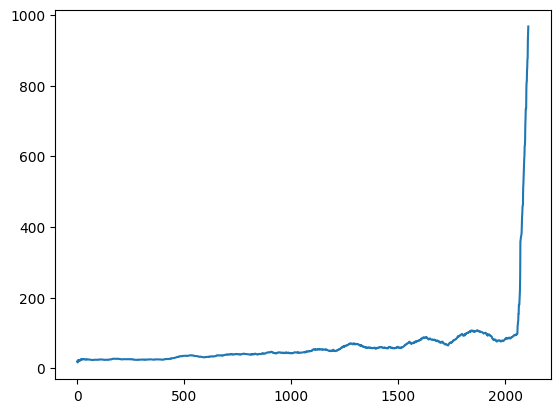

In [3]:
trainer = CartPoleTrainer(render=False)
trainer.run()